In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

# Exercises 4a point 1
In each sample increase the number of dimensions from 3 to L>3, by introducing L-3
additional dimensions with noisy inputs. Study how visualization with t-SNE and clustering
with DBSCAN are affected by this increase in dimensionality.
To mix the information between all L dimensions while preserving the distances between
points, one can also perform some rotation of data with orthonormal random matrices M in
O(L): x → M.x


Best perplexity to use -> 20

Best epsilon to use -> 108

Best minPts to use -> 3 or 5

In [2]:
from scipy.stats import ortho_group

### Dataset

In [3]:
#fname,fnamey="x_def_3d.dat","y_def_3d.dat"
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 1000   D= 3


### Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

In [4]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            if dij<dm:
                dm = dij
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)

1552.6302096770091
mean minimum distance between points:  18.55757910124019


### Augmenting dimensionality of the dataset by adding noisy additional dimensions

In [5]:
L = 20 # total dimension of the points in the dataset
std = 0.1 * mean_min_dist #standard deviation of the white noise
white_noise = np.random.normal(scale=std, size=(x.shape[0], L-x.shape[1]))

x_augmented = np.column_stack((x, white_noise))

print(x.shape, x_augmented.shape, white_noise.shape)

Rot = ortho_group.rvs(dim=L)  #generating a random rotation matrix
x_augmented = np.dot(Rot,x_augmented.T) #rotating the whole dataset

(1000, 3) (1000, 20) (1000, 17)


### t-SNE on dataset with noisy dimensions

#### Varying the dimensions of the dataset and the amount on noise

In [6]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

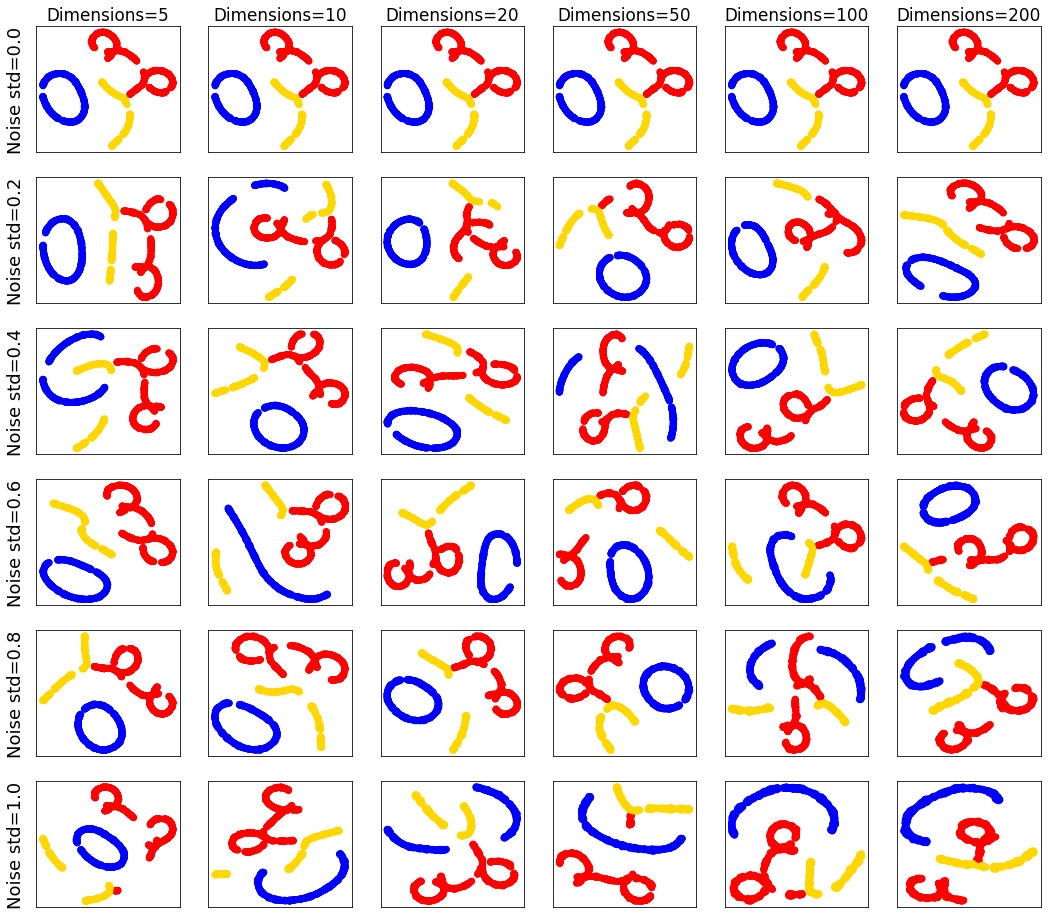

In [7]:
np.random.seed(0)
n_samples = N
n_components = 2
Dimensions = [5,10,20,50,100, 200]
Np = len(Dimensions)
Noise_rates = [0.,0.2, 0.4, 0.6, 0.8, 1.]
Nc = len(Noise_rates)
mycmap = ListedColormap(["blue","red","gold" ])
perplexity = 20
(fig, subplots) = plt.subplots(Nc,Np , figsize=(3*Np, 2.7*Nc))

X_all = [None]
for i, dim in enumerate(Dimensions):
    
    for j, noise_r in enumerate(Noise_rates):
    
        ######## DATA GENERATION ##############

        L = dim # total dimension of the points in the dataset
        std = noise_r * mean_min_dist #standard deviation of the white noise
        white_noise = np.random.normal(scale=std, size=(x.shape[0], L-x.shape[1]))

        x_augmented = np.column_stack((x, white_noise))

        Rot = ortho_group.rvs(dim=L)  #generating a random rotation matrix
        x_augmented = np.dot(Rot,x_augmented.T).T #rotating the whole dataset
        ######### PLOTS ################    

        ax = subplots[j,i]

        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='random',
                             random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(x_augmented)
        t1 = time()
        
        if(j==0):
            ax.set_title("Dimensions=%d" % dim)
            
        if(i==0):
            ax.set_ylabel("Noise std=%.1f" % noise_r, size=18)

            
        ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        X_all.append(Y)
    
plots = plt.show()

(-55.896573829650876, 57.02265338897705, -57.12123107910156, 53.88652038574219)

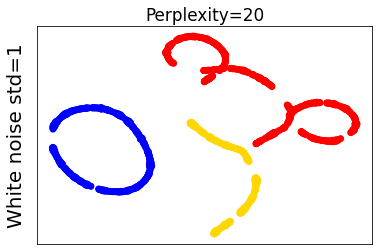

In [8]:
mycmap = ListedColormap(["blue","red","gold" ])

(fig, ax) = plt.subplots(1)

perplexity = 20
n_components = 2
t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='random',
                     random_state=0, perplexity=perplexity)
Y = tsne.fit_transform(data)
t1 = time()
ax.set_title("Perplexity=%d" % perplexity)
ax.set_ylabel("White noise std=%d" % noise_r, size=20)
ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
ax.tick_params(left=False,bottom=False)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis('tight')

### DBSCAN on dataset with noisy dimensions

#### Varying the dimensions of the dataset and the amount on noise

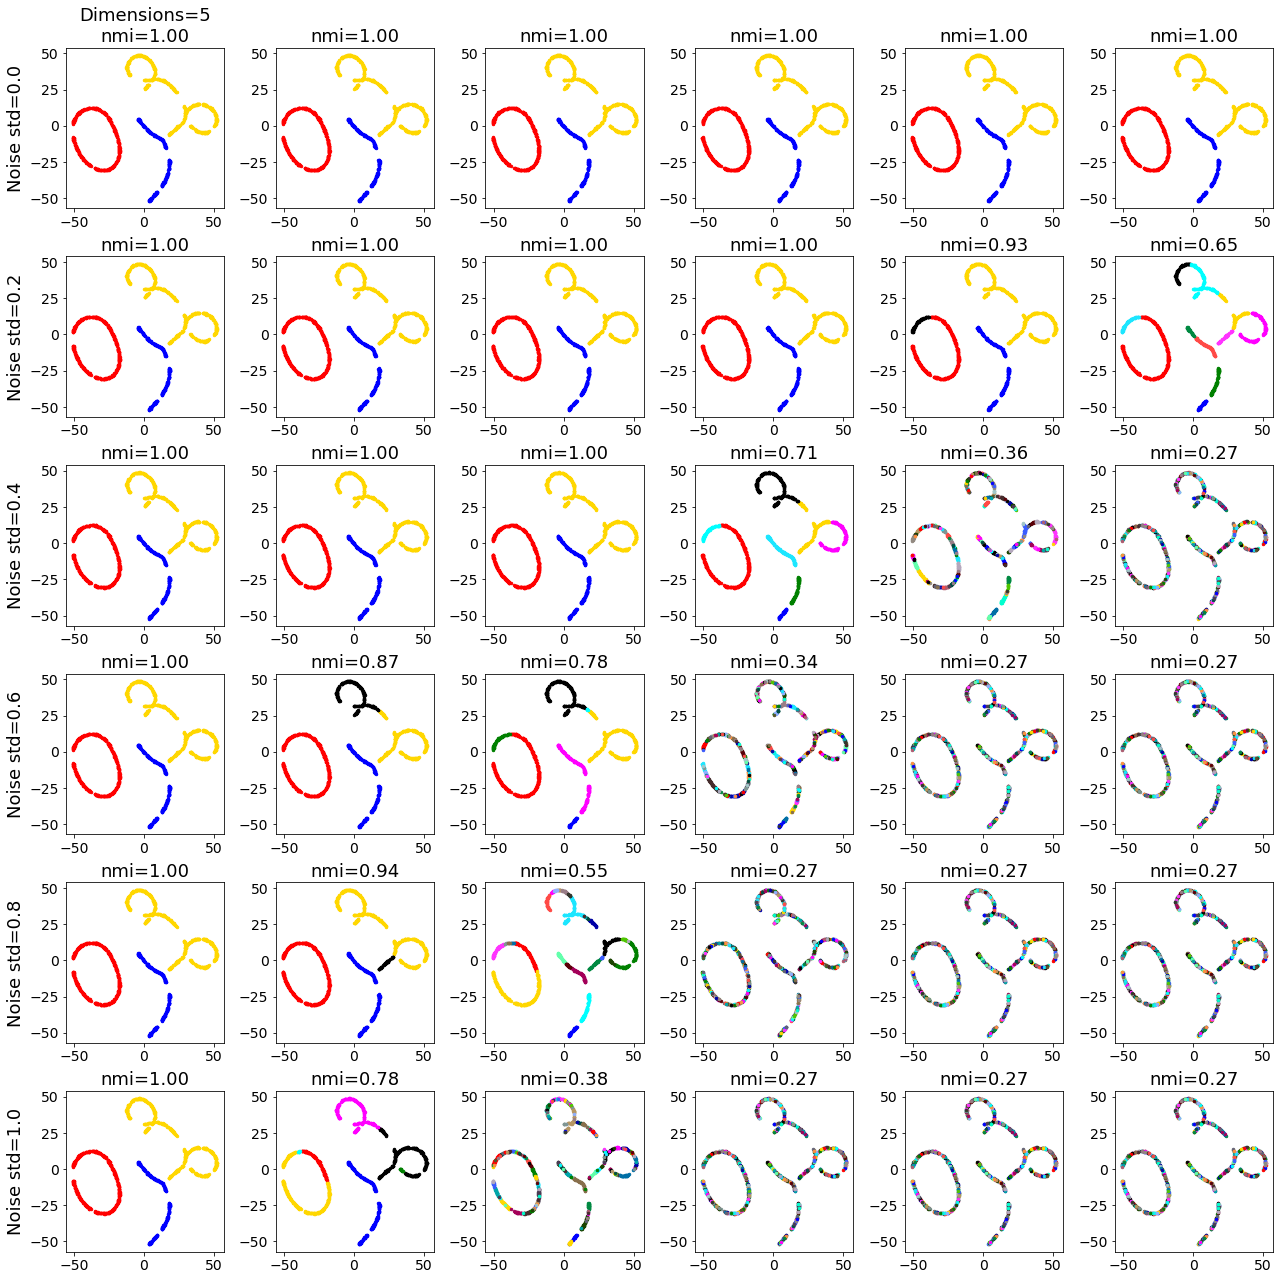

In [15]:
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[1] # best visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
    
eps = 108.
#min_sample_range = [3,5,10,20]
min_samples = 0

Dimensions = [5,10,20,50,100, 200]
Np = len(Dimensions)
Noise_rates = [0,0.2, 0.4, 0.6, 0.8, 1.]
Nc = len(Noise_rates)

(fig, subplots) = plt.subplots(Np,Nc , figsize=(3*Nc, 3*Np))


for i, dim in enumerate(Dimensions):
    for j, noise_r in enumerate(Noise_rates):
        
        
        ######## DATA GENERATION ##############

        L = dim # total dimension of the points in the dataset
        std = noise_r * mean_min_dist #standard deviation of the white noise
        white_noise = np.random.normal(scale=std, size=(x.shape[0], L-x.shape[1]))

        x_augmented = np.column_stack((x, white_noise))

        Rot = ortho_group.rvs(dim=L)  #generating a random rotation matrix
        x_augmented = np.dot(Rot,x_augmented.T).T #rotating the whole dataset
        
        X = x_augmented
        
        ax = subplots[j,i]
        
        ######## CLUSTERING ##################        
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_ 
        plotting_ax(X2D,y_hat,ax)
        nmi=NMI(y_hat, y_true)
        
        if(j==0):
            ax.set_title("Dimensions=%d\nnmi=%.2f" % (dim,nmi), size=18)
            
        else:
            ax.set_title("nmi=%.2f" % nmi, size=18)
            
        if(i==0):
            ax.set_ylabel("Noise std=%.1f" % noise_r, size=18)
            
        else:
            ax.set_title("nmi=%.2f" % nmi, size=18)
        
plt.tight_layout(h_pad=0.5)
plt.show()